# This notebook contains the code to train SynthMorph with 3D sinograms
# Here a test has been carried out to try to know if the model can be trained with data containing a single projection

## 1. Import of all the libraries and packages needed to run the code

In [47]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import odl
from tensorflow.keras.layers import Dense

## 2. Construction of the foreward projection operation : the ray transform

In [2]:
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(0, 2 * np.pi), grid=odl.discr.grid.RectGrid(np.linspace(0,2*np.pi,360)))
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(-60, 60), grid=odl.discr.grid.RectGrid(np.linspace(-60, 60, 512)))
# Geometry with large fan angle
geometry = odl.tomo.geometry.conebeam.FanFlatGeometry(
    apart=angle_partition, dpart=detector_partition, src_radius=40, det_radius=40)
# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

## 3. Creation of the 10 pairs of sinograms

In [56]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions. Warning : the shape must be consistent with the operator's shape!
num_dim = len(in_shape)
num_label = 16
num_maps = 10

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    fp_lab = ray_trafo(lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    fp_lab_bis = np.zeros((16, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    fp_lab_bis[8:9, 0:0+fp_lab.shape[1]] = fp_lab[0:1,:]
    label_maps.append(np.uint8(fp_lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    fp_warped_lab = ray_trafo(warped_lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    fp_warped_lab_bis = np.zeros((16, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    fp_warped_lab_bis[8:9, 0:0+fp_warped_lab.shape[1]] = fp_warped_lab[0:1,:]
    label_maps.append(np.uint8(fp_warped_lab_bis))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]


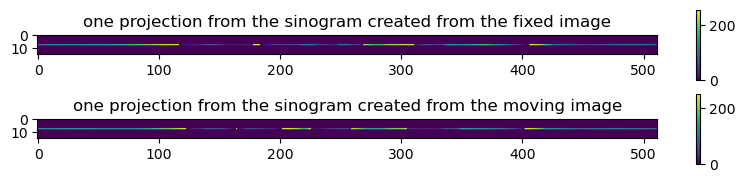

In [57]:
# Visualise a sinogram and its warped version
fig = plt.figure(figsize=(10, 2))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(fp_lab_bis)
plt.title("one projection from the sinogram created from the fixed image")
plt.colorbar()

fig.add_subplot(rows, columns, 2)
plt.imshow(fp_warped_lab_bis)
plt.title("one projection from the sinogram created from the moving image")
plt.colorbar()

## 4. Creation of 20 grey-scale sinograms to train the model

In [35]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape= (16, 512), # shape of the sinogram (must be a multiple of 16)
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several sinogram contrasts from a given sinogram (here from the first "fixed" grey-scale sinogram).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 31ms/step


## 5. Creation of the model

In [36]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape = (16, 512), # shape of the sinogram (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [16]*8),
    reg_field='warp',
)

# Define regularisation strength.
regularization_strength = 0

# Get the regularisation losses from the VxmDense layer.
regularisation_loss = tf.reduce_sum(reg_model.losses)

# Define the custom loss function with regularisation.
def custom_loss(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss += regularisation_strength * regularisation_loss
    return loss

reg_model.compile(loss=custom_loss)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.
    
# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

## 6. Train SynthMorph over few epochs

In [45]:
# Train model for a few epochs. 
# Re-running the cell will continue training.

gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=1000,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

Epoch 1/1000
100/100 [==============================] - 22s 224ms/step - loss: 0.9473
Epoch 2/1000
100/100 [==============================] - 22s 223ms/step - loss: 0.9456
Epoch 3/1000
100/100 [==============================] - 22s 220ms/step - loss: 0.9453
Epoch 4/1000
100/100 [==============================] - 22s 220ms/step - loss: 0.9445
Epoch 5/1000
100/100 [==============================] - 22s 220ms/step - loss: 0.9464
Epoch 6/1000
100/100 [==============================] - 22s 223ms/step - loss: 0.9441
Epoch 7/1000
100/100 [==============================] - 22s 219ms/step - loss: 0.9452
Epoch 8/1000
100/100 [==============================] - 22s 219ms/step - loss: 0.9458
Epoch 9/1000
100/100 [==============================] - 22s 223ms/step - loss: 0.9452
Epoch 10/1000
100/100 [==============================] - 22s 219ms/step - loss: 0.9448
Epoch 11/1000
100/100 [==============================] - 22s 219ms/step - loss: 0.9462
Epoch 12/1000
100/100 [=============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



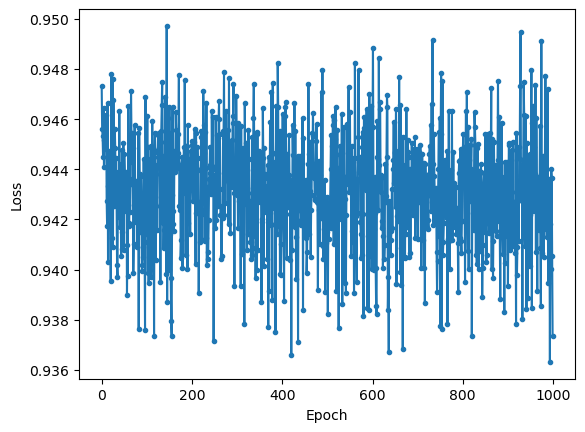

In [46]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');